In [2]:
#Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


## Data Prep

In [142]:
#Read data
df = pd.read_csv('LSTM-Multivariate_pollution.csv')
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [143]:
#Map wnd_dir
mapping = {
    'SE' : 1,
    'NW' : 2,
    'cv' : 3,
    'NE' : 4
}
df['wnd_dir'] = df['wnd_dir'].str.strip().str.upper()
df['wnd_dir'] = df['wnd_dir'].map(mapping)
train_dates = df['date'].values
df = df.drop(['date'], axis = 1)
df.fillna(df.mean(), inplace=True)

In [144]:
#Make sure all values are floats
cols = df.columns
df = df[cols].astype('float')
df.dtypes

,0
pollution,float64
dew,float64
temp,float64
press,float64
wnd_dir,float64
wnd_spd,float64
snow,float64
rain,float64


In [145]:
#Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled


array([[ 0.37925225, -1.23558917, -1.34984913, ..., -0.44189031,
        -0.06937208, -0.13770552],
       [ 0.58521158, -1.16628508, -1.34984913, ..., -0.4240982 ,
        -0.06937208, -0.13770552],
       [ 0.70445119, -0.8890687 , -1.43186175, ..., -0.40630608,
        -0.06937208, -0.13770552],
       ...,
       [-0.91070355, -1.65141375, -1.26783651, ...,  4.3741754 ,
        -0.06937208, -0.13770552],
       [-0.93238347, -1.65141375, -1.34984913, ...,  4.45453979,
        -0.06937208, -0.13770552],
       [-0.88902362, -1.58210965, -1.26783651, ...,  4.51711206,
        -0.06937208, -0.13770552]])

## Multivariate prep

In [146]:
#Training series
trainX = []
#Prediction
trainY = []
#Number of days we want to predict
n_days_pred = 1
#Number of days we want to use as data
n_days_data = 14

In [147]:
#Function to create prediction using past data
for i in range(n_days_data, len(df_scaled)- n_days_pred + 1):
  trainX.append(df_scaled[i - n_days_data:i, 0:df_scaled.shape[1]])
  trainY.append(df_scaled[i+n_days_pred-1 : i+n_days_pred,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

## LSTM Model

In [148]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1],trainX.shape[2]),return_sequences = True))
model.add(LSTM(32,activation = 'relu', return_sequences = False))
model.add(Dense(trainY.shape[1]))
model.add(Dropout(0.1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 14, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
#Fit the model
history = model.fit(trainX, trainY, epochs = 5, batch_size = 14, validation_split = 0.1, verbose = 1)

Epoch 1/5
2815/2815 ━━━━━━━━━━━━━━━━━━━━ 72s 23ms/step - loss: 0.2739 - val_loss: 0.0724
Epoch 2/5
2815/2815 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - loss: 0.1868 - val_loss: 0.0584
Epoch 3/5
2815/2815 ━━━━━━━━━━━━━━━━━━━━ 80s 19ms/step - loss: 0.1712 - val_loss: 0.0588
Epoch 4/5
2815/2815 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - loss: 0.1712 - val_loss: 0.0807
Epoch 5/5
2815/2815 ━━━━━━━━━━━━━━━━━━━━ 90s 21ms/step - loss: 0.1655 - val_loss: 0.0715


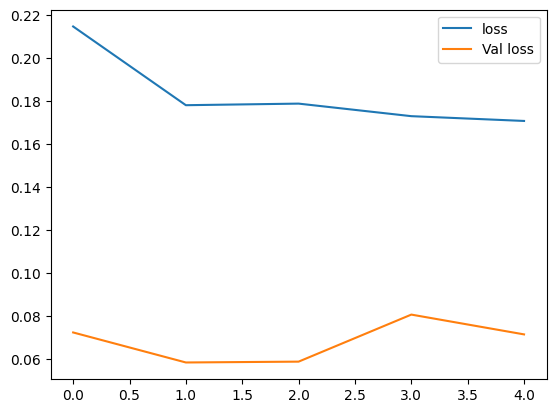

In [150]:
#Plot the loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.legend()

## Model Predictions

In [151]:
#Prediction
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 14
n_future_pred = 14
pred_period = pd.date_range(list(train_dates)[-n_past], periods = n_future_pred, freq=us_bd).tolist()
prediction = model.predict(trainX[-n_future_pred:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [152]:
#Create copy for inverse transformation to match shape

copy = np.repeat(prediction, df_scaled.shape[1], axis = 1)
#Remove everything not important
pred = scaler.inverse_transform(copy)[:,0]

                      date  pollution
43752  2014-12-30 00:00:00      189.0
43753  2014-12-30 01:00:00       97.0
43754  2014-12-30 02:00:00       81.0
43755  2014-12-30 03:00:00       28.0
43756  2014-12-30 04:00:00       25.0
43757  2014-12-30 05:00:00        9.0
43758  2014-12-30 06:00:00        9.0
43759  2014-12-30 07:00:00       13.0
43760  2014-12-30 08:00:00       17.0
43761  2014-12-30 09:00:00       16.0
43762  2014-12-30 10:00:00       25.0
43763  2014-12-30 11:00:00       48.0
43764  2014-12-30 12:00:00       49.0
43765  2014-12-30 13:00:00       73.0
43766  2014-12-30 14:00:00       65.0
43767  2014-12-30 15:00:00       55.0
43768  2014-12-30 16:00:00       60.0
43769  2014-12-30 17:00:00       63.0
43770  2014-12-30 18:00:00       79.0
43771  2014-12-30 19:00:00       35.0
43772  2014-12-30 20:00:00       26.0
43773  2014-12-30 21:00:00       20.0
43774  2014-12-30 22:00:00        8.0
43775  2014-12-30 23:00:00       16.0
43776  2014-12-31 00:00:00       10.0
43777  2014-

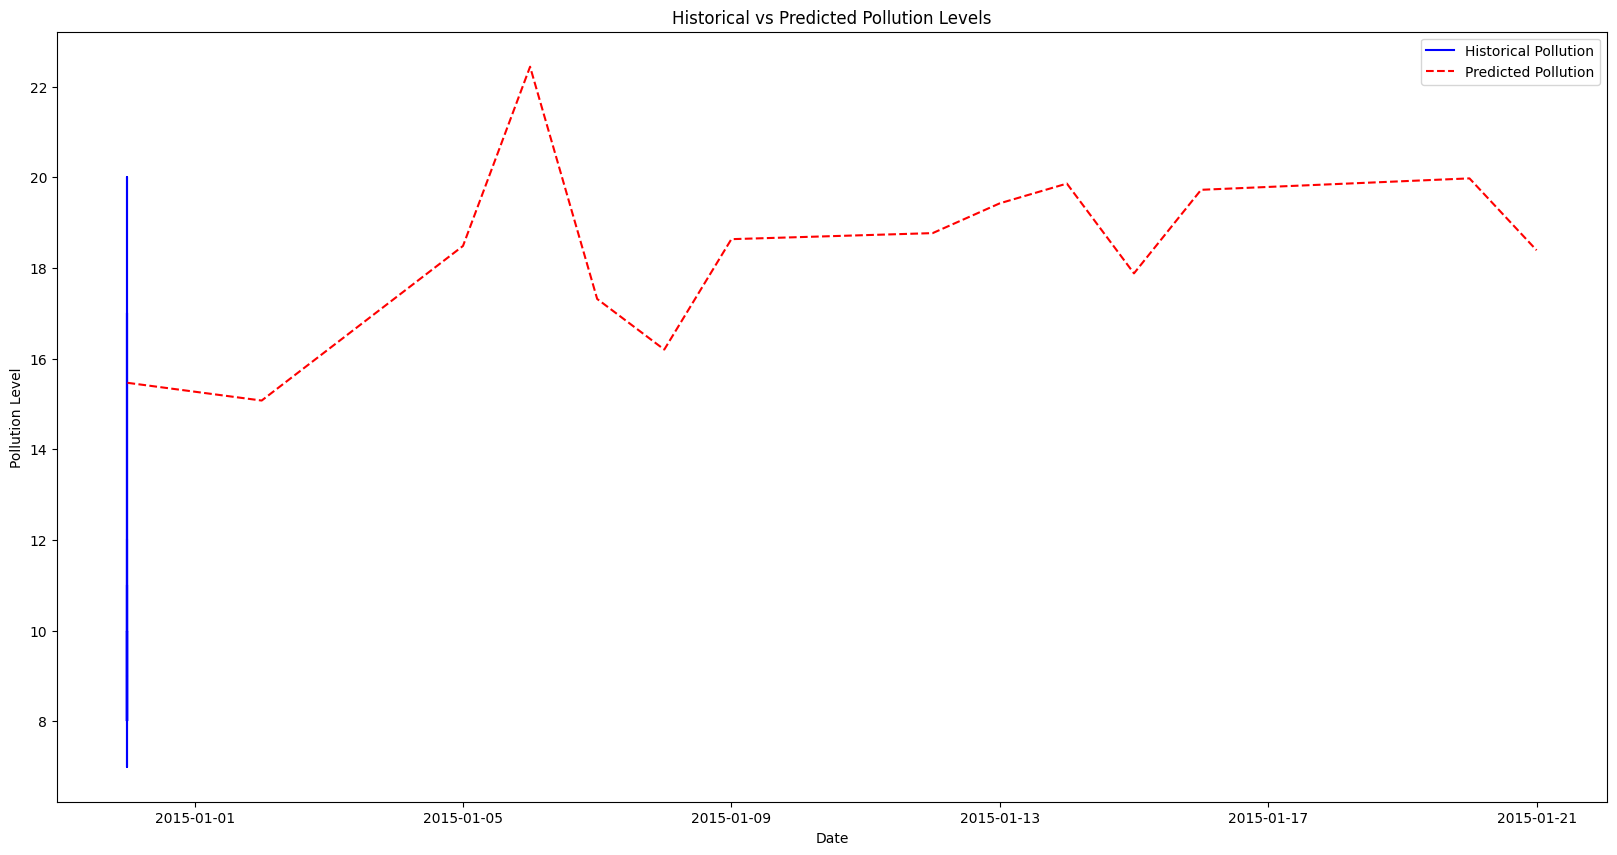

In [166]:
#Setup graph
import pytz
prediction = prediction.ravel()
forecast_dates = []
for i in pred_period:
  forecast_dates.append(i.date())

#Create df's
df_pred = pd.DataFrame({'Dates': forecast_dates, 'Pollution': pred})
df_base = pd.DataFrame({'date': train_dates, 'pollution': df['pollution']})

print(df_base.loc[df_base['date'] >= '2014-12-30'])

# Normalize the dates in df_base as well to ensure consistency
df_base['date'] = pd.to_datetime(df_base['date']).dt.normalize()
df_base = df_base.loc[df_base['date'] >= '2014-12-31']

# Plotting the data after normalization
plt.figure(figsize=(20, 10))
plt.plot(df_base['date'], df_base['pollution'], label='Historical Pollution', color='blue')
plt.plot(df_pred['Dates'], df_pred['Pollution'], label='Predicted Pollution', color='red', linestyle='--')

plt.title('Historical vs Predicted Pollution Levels')
plt.xlabel('Date')
plt.ylabel('Pollution Level')
plt.legend()

# Show the plot
plt.show()
